# Web-Scraping

In [1]:
# import libraries

import collections
import requests
from bs4 import BeautifulSoup, element
import pandas as pd
import urllib.parse

import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
import pandas as pd
import re
import time

In [2]:
# web scraping

def scrape_puma():
    titles = []
    prices =[]
    colors=[]
    badges =[]
    categories = []
    old_prices = []


    #get the urls of subpages
    url = "https://uk.puma.com/uk/en/home"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    #print(soup.prettify())
    links =[]
    for link in soup.findAll('li',class_='p-sub-nav-tier2'):
        new_link = link.find('a').get('href')
        if new_link.startswith('/uk/en/collections/lifestyle/'):
                Collection_links = urllib.parse.urljoin(url,new_link)
                if Collection_links not in links:
                    links.append(Collection_links)
    #print("Link to Collections: " + str(links))
    
    
    for link in links:
        driver = webdriver.Chrome()
        driver.get(link) 
        driver.implicitly_wait(5)
        close_button = driver.find_element_by_xpath('//*[@id="wps_popup"]/div/div[1]')
        close_button.click()
        stop = False
        while not stop:
            showmore = driver.find_elements_by_class_name("show-more-button")
            if len(showmore)>1:
                showmore_button = driver.find_element_by_xpath('//*[@id="product-search-results"]/div[2]/div[4]/div/div[3]/div[3]/div[1]/div/button[1]')
                if showmore_button.is_enabled():
                    driver.execute_script("arguments[0].click();", showmore_button)
                    time.sleep(4)
                else:
                    stop = True
            else:
                stop = True

        page_source = driver.page_source

        #page = requests.get(link)
        #soup = BeautifulSoup(page.content,"html.parser")
        soup = BeautifulSoup(page_source,"html.parser")

        title_tags = soup.findAll("a", class_ = 'product-tile-title product-tile__title pdp-link line-item-limited line-item-limited--2')
        category_tags = soup.find('h1', class_ = 'product-results-title').text
        category_tags = category_tags.replace('\n',"") ####

        for title in title_tags:
            titles.append(title.text)
            categories.append(category_tags)
    #print(titles)


        color_tags = soup.findAll('p',class_ = 'swatch-title product-tile__swatch-title swatch-title-carousel')
        for color in color_tags:
            color_ = color.get('data-swatch-count')
            color_ =int(color_)
            colors.append(color_)
        
        price_tags = soup.findAll("div", class_ = 'product-tile-info-price')
        for price in price_tags: 
            prices.append(price.text)

        
        badge_tags = soup.findAll('div', class_ = 'product-tile-badge-container')
        for badge in badge_tags:
            badge = badge.text.replace('\n',"")
            badges.append(badge)
        
        driver.close()
    

    for price in prices:
        price_list = []
        price = price.split('\n')
        for i in range(len(price)):
            if  price[i] != '':
                price[i] = price[i].replace('£','')
                price[i] = float(price[i])
                price_list.append(price[i])
        old_price = max(price_list)
        old_prices.append(old_price)

    puma_data = pd.DataFrame({'Title' : titles, 'Category' : categories, "Color": colors, "Price": old_prices, "Badge": badges})
    
    return puma_data

In [3]:
#%%
puma_data = scrape_puma()

In [4]:
# save file
puma_data.to_csv('Puma_Dataset_11-11-2021.csv', index=False)

# Data Cleansing

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#read file
puma_df = pd.read_csv('Puma_Dataset_11-11-2021.csv')
puma_df

,Title,Category,Color,Price,Badge
0,PUMA x SANTA CRUZ Women's Cropped Hoodie,SUSTAINABLE CLOTHING & SHOES,1,60.0,Sustainable Material
1,PUMA x SANTA CRUZ Twill Pants,SUSTAINABLE CLOTHING & SHOES,2,70.0,Sustainable Material
2,PUMA x SANTA CRUZ Twill Pants,SUSTAINABLE CLOTHING & SHOES,2,70.0,Sustainable Material
3,PUMA x SANTA CRUZ Sweatpants,SUSTAINABLE CLOTHING & SHOES,3,60.0,Sustainable Material
4,PUMA x SANTA CRUZ Sweatpants,SUSTAINABLE CLOTHING & SHOES,3,60.0,Sustainable Material
...,...,...,...,...,...
1601,Wild Rider SC Trainers,MMQ,1,120.0,NaN
1602,MMQ Pocket Tee,MMQ,6,45.0,NaN
1603,MMQ EARTHBREAK Utility Men's Vest,MMQ,1,115.0,NaN
1604,MMQ EARTHBREAK Men's Shorts,MMQ,1,60.0,NaN


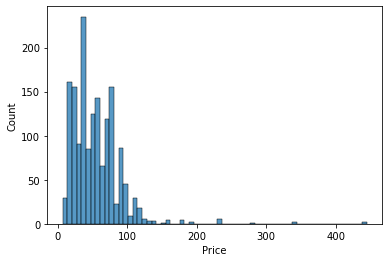

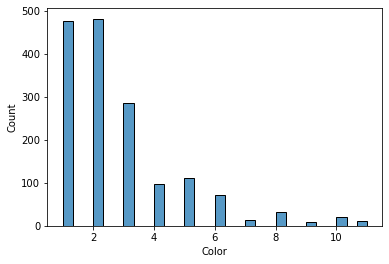

In [5]:
# numeric variables overivew
# price overivew
sns.histplot(puma_df['Price'],kde=False)
plt.show()

# color overview
sns.histplot(puma_df['Color'],kde= False)
plt.show()


In [6]:
#category variables overview
# Category
puma_df['Category'].unique()

array(['SUSTAINABLE CLOTHING & SHOES', 'Suede', 'Cali', 'MAYZE', 'Mirage',
       'SUEDE MAYU', 'PUMA Rider Pack', 'RS-Collection', 'MMQ'],
      dtype=object)

In [7]:
puma_df['Badge'].unique()

array(['Sustainable Material', nan, 'Vegan', 'Exclusive'], dtype=object)

In [8]:
#%%duplicates
dups = puma_df.duplicated()
print(dups.any())
print(puma_df[dups]) #return the problematic row

True
                              Title                      Category  Color  \
2     PUMA x SANTA CRUZ Twill Pants  SUSTAINABLE CLOTHING & SHOES      2   
4      PUMA x SANTA CRUZ Sweatpants  SUSTAINABLE CLOTHING & SHOES      3   
5      PUMA x SANTA CRUZ Sweatpants  SUSTAINABLE CLOTHING & SHOES      3   
7             PUMA x SANTA CRUZ Tee  SUSTAINABLE CLOTHING & SHOES      3   
8             PUMA x SANTA CRUZ Tee  SUSTAINABLE CLOTHING & SHOES      3   
...                             ...                           ...    ...   
1597                 MMQ Pocket Tee                           MMQ      6   
1598            MMQ Full-Zip Hoodie                           MMQ      4   
1599          MMQ Mock Neck Sweater                           MMQ      2   
1600            MMQ Full-Zip Hoodie                           MMQ      4   
1602                 MMQ Pocket Tee                           MMQ      6   

      Price                 Badge  
2      70.0  Sustainable Material  
4      60.

In [9]:
#drop duplicates
puma_df.drop_duplicates(inplace=True)
print(puma_df)

                                         Title                      Category  \
0     PUMA x SANTA CRUZ Women's Cropped Hoodie  SUSTAINABLE CLOTHING & SHOES   
1                PUMA x SANTA CRUZ Twill Pants  SUSTAINABLE CLOTHING & SHOES   
3                 PUMA x SANTA CRUZ Sweatpants  SUSTAINABLE CLOTHING & SHOES   
6                        PUMA x SANTA CRUZ Tee  SUSTAINABLE CLOTHING & SHOES   
9       PUMA x SANTA CRUZ Women's Coach Jacket  SUSTAINABLE CLOTHING & SHOES   
...                                        ...                           ...   
1594                     MMQ Mock Neck Sweater                           MMQ   
1601                    Wild Rider SC Trainers                           MMQ   
1603         MMQ EARTHBREAK Utility Men's Vest                           MMQ   
1604               MMQ EARTHBREAK Men's Shorts                           MMQ   
1605      PUMA x EARTHBREAK Mirage OG Trainers                           MMQ   

      Color  Price                 Badg

In [10]:
# detect if there are any empty celss
puma_df.isna().any()

Title       False
Category    False
Color       False
Price       False
Badge        True
dtype: bool

In [11]:
# fill na
puma_df = puma_df.fillna('Not Found')

In [12]:
# check df
puma_df.isna().any()

Title       False
Category    False
Color       False
Price       False
Badge       False
dtype: bool

In [13]:
# find the number of unique entries for all columns
puma_df.nunique()

Title       833
Category      9
Color        11
Price        50
Badge         4
dtype: int64

In [14]:
# Feature Engineering
temp = pd.get_dummies(puma_df,drop_first= False, columns=['Badge'])
puma_df = temp.drop(columns=['Badge_Not Found'])
puma_df

,Title,Category,Color,Price,Badge_Exclusive,Badge_Sustainable Material,Badge_Vegan
0,PUMA x SANTA CRUZ Women's Cropped Hoodie,SUSTAINABLE CLOTHING & SHOES,1,60.0,0,1,0
1,PUMA x SANTA CRUZ Twill Pants,SUSTAINABLE CLOTHING & SHOES,2,70.0,0,1,0
3,PUMA x SANTA CRUZ Sweatpants,SUSTAINABLE CLOTHING & SHOES,3,60.0,0,1,0
6,PUMA x SANTA CRUZ Tee,SUSTAINABLE CLOTHING & SHOES,3,30.0,0,1,0
9,PUMA x SANTA CRUZ Women's Coach Jacket,SUSTAINABLE CLOTHING & SHOES,2,115.0,0,1,0
...,...,...,...,...,...,...,...
1594,MMQ Mock Neck Sweater,MMQ,2,90.0,0,0,0
1601,Wild Rider SC Trainers,MMQ,1,120.0,0,0,0
1603,MMQ EARTHBREAK Utility Men's Vest,MMQ,1,115.0,0,0,0
1604,MMQ EARTHBREAK Men's Shorts,MMQ,1,60.0,0,0,0


In [15]:
# mayze dataframe
mayze_df = puma_df.loc[puma_df['Category'] == 'MAYZE']
mayze_df = mayze_df[~mayze_df.Title.str.contains("Boots")]
mayze_df.loc[:,'Am'] = 'DL'
mayze_df

,Title,Category,Color,Price,Badge_Exclusive,Badge_Sustainable Material,Badge_Vegan,Am
1352,Mayze Women's Sneakers,MAYZE,3,80.0,0,0,0,DL
1355,Mayze Women's Trainers,MAYZE,3,80.0,0,0,0,DL
1358,Mayze Gum Women's Trainers,MAYZE,2,90.0,0,0,0,DL
1360,Mayze Mid Women's Trainers,MAYZE,2,110.0,0,0,0,DL
1362,Mayze Tech Women's Trainers,MAYZE,3,90.0,0,0,0,DL
1364,Mayze Tech Women's Trainers,MAYZE,3,110.0,0,0,0,DL
1365,Mayze Santa Cruz Women's Trainers,MAYZE,2,110.0,0,0,0,DL
1368,PUMA x PUMA Mayze Mid Women's Trainers,MAYZE,1,115.0,0,0,0,DL
1369,Mayze Infuse Women's Trainers,MAYZE,1,90.0,0,1,0,DL
1371,Mayze Reflective Women’s Trainers,MAYZE,2,95.0,1,0,0,DL


In [16]:
#calidream dataframe
cali_df = puma_df.loc[puma_df['Category'] == 'Cali']
calidream_df = cali_df[cali_df['Title'].str.contains('Dream')]
calidream_df.loc[:,'Am'] = 'Winnie'
calidream_df

/Users/xiaohangan/opt/anaconda3/envs/DTVC/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Title,Category,Color,Price,Badge_Exclusive,Badge_Sustainable Material,Badge_Vegan,Am
1301,Cali Dream Women's Trainers,Cali,3,80.0,0,0,0,Winnie


In [17]:
#cruiserider dataframe
cruise_df = puma_df.loc[puma_df['Category'] == 'PUMA Rider Pack']
cruiserider_df = cruise_df[cruise_df['Title'].str.contains('Cruise Rider')]
cruiserider_df = cruiserider_df[cruiserider_df['Title'].str.contains('Women')]
cruiserider_df = cruiserider_df[~cruiserider_df.Title.str.contains("Boots")]
cruiserider_df.loc[:,'Am'] = 'Winnie'
cruiserider_df

,Title,Category,Color,Price,Badge_Exclusive,Badge_Sustainable Material,Badge_Vegan,Am
1440,Cruise Rider Women's Sneakers,PUMA Rider Pack,6,80.0,1,0,0,Winnie
1452,PUMA x LIBERTY Cruise Rider NU Women's Trainers,PUMA Rider Pack,1,100.0,0,0,0,Winnie
1455,Cruise Rider Flair Women's Trainers,PUMA Rider Pack,1,80.0,0,0,1,Winnie
1456,Cruise Rider Infuse Women's Trainers,PUMA Rider Pack,1,90.0,0,1,0,Winnie
1495,Cruise Rider GL Women's Trainers,PUMA Rider Pack,1,80.0,0,0,0,Winnie
1509,Cruise Rider Lace Women's Trainers,PUMA Rider Pack,2,90.0,0,0,0,Winnie
1512,PUMA x FELIPE PANTONE Cruise Rider Women's Tra...,PUMA Rider Pack,1,100.0,0,0,1,Winnie
1515,Cruise Rider Metal Women's Trainers,PUMA Rider Pack,3,80.0,0,0,1,Winnie
1529,Cruise Rider RE.GEN Women's Sneakers,PUMA Rider Pack,1,90.0,0,1,0,Winnie
1534,Cruise Rider Ocean Queen Women's Trainers,PUMA Rider Pack,1,90.0,0,0,0,Winnie


In [18]:
#concat dataframe
am_df = pd.concat([mayze_df,calidream_df,cruiserider_df])

In [19]:
# change dummy variable
am_df = pd.get_dummies(am_df,drop_first= True, columns=['Am'])
am_df

,Title,Category,Color,Price,Badge_Exclusive,Badge_Sustainable Material,Badge_Vegan,Am_Winnie
1352,Mayze Women's Sneakers,MAYZE,3,80.0,0,0,0,0
1355,Mayze Women's Trainers,MAYZE,3,80.0,0,0,0,0
1358,Mayze Gum Women's Trainers,MAYZE,2,90.0,0,0,0,0
1360,Mayze Mid Women's Trainers,MAYZE,2,110.0,0,0,0,0
1362,Mayze Tech Women's Trainers,MAYZE,3,90.0,0,0,0,0
1364,Mayze Tech Women's Trainers,MAYZE,3,110.0,0,0,0,0
1365,Mayze Santa Cruz Women's Trainers,MAYZE,2,110.0,0,0,0,0
1368,PUMA x PUMA Mayze Mid Women's Trainers,MAYZE,1,115.0,0,0,0,0
1369,Mayze Infuse Women's Trainers,MAYZE,1,90.0,0,1,0,0
1371,Mayze Reflective Women’s Trainers,MAYZE,2,95.0,1,0,0,0


# Feature Engineering

In [5]:
# t-test 
import statsmodels.api as sm

In [21]:
#price
ttest = sm.stats.ttest_ind(am_df[am_df.Am_Winnie ==0].Price,am_df[am_df.Am_Winnie ==1].Price)
tstat = ttest[0]
pvalue = ttest[1]

print('the tstat for Am differences in price is =', tstat)
print('the pvalue is =', pvalue)   

the tstat for Am differences in price is = 2.4500473955491446
the pvalue is = 0.021327952179864884


In [22]:
#color

ttest = sm.stats.ttest_ind(am_df[am_df.Am_Winnie ==0].Color,am_df[am_df.Am_Winnie ==1].Color)
tstat = ttest[0]
pvalue = ttest[1]

print('the tstat for Am differences in color is =', tstat)
print('the pvalue is =', pvalue)  

the tstat for Am differences in color is = 0.3244428422615249
the pvalue is = 0.74819869132009


## Sustaiable products

In [4]:
#drop duplicated rows
sus_df = puma_df.drop(columns=['Category'])
dup = sus_df.duplicated()
print(dup.any)
print(sus_df[dup])

sus_df.drop_duplicates(inplace=True)
print(sus_df)

<bound method NDFrame._add_numeric_operations.<locals>.any of 0       False
1       False
2        True
3       False
4        True
        ...  
1601     True
1602     True
1603    False
1604    False
1605     True
Length: 1606, dtype: bool>
                                     Title  Color  Price                 Badge
2            PUMA x SANTA CRUZ Twill Pants      2   70.0  Sustainable Material
4             PUMA x SANTA CRUZ Sweatpants      3   60.0  Sustainable Material
5             PUMA x SANTA CRUZ Sweatpants      3   60.0  Sustainable Material
7                    PUMA x SANTA CRUZ Tee      3   30.0  Sustainable Material
8                    PUMA x SANTA CRUZ Tee      3   30.0  Sustainable Material
...                                    ...    ...    ...                   ...
1599                 MMQ Mock Neck Sweater      2   90.0                   NaN
1600                   MMQ Full-Zip Hoodie      4  100.0                   NaN
1601                Wild Rider SC Trainers    

In [5]:
sus_df.describe()

,Color,Price
count,905.000000,905.000000
mean,1.933702,55.783425
std,1.384979,34.013232
min,1.000000,7.000000
25%,1.000000,35.000000
50%,1.000000,50.000000
75%,2.000000,70.000000
max,11.000000,445.000000


In [24]:
#sustainable product price
sus_df.rename(columns = {'Badge_Sustainable Material': "B_S"}, inplace=True)
sus_df

,Title,Color,Price,Badge_Exclusive,B_S,Badge_Vegan
0,PUMA x SANTA CRUZ Women's Cropped Hoodie,1,60.0,0,1,0
1,PUMA x SANTA CRUZ Twill Pants,2,70.0,0,1,0
3,PUMA x SANTA CRUZ Sweatpants,3,60.0,0,1,0
6,PUMA x SANTA CRUZ Tee,3,30.0,0,1,0
9,PUMA x SANTA CRUZ Women's Coach Jacket,2,115.0,0,1,0
...,...,...,...,...,...,...
1590,MMQ Pocket Tee,6,45.0,0,0,0
1593,MMQ Full-Zip Hoodie,4,100.0,0,0,0
1594,MMQ Mock Neck Sweater,2,90.0,0,0,0
1603,MMQ EARTHBREAK Utility Men's Vest,1,115.0,0,0,0


In [25]:
# t-test (compare sustainable products with normal products)
ttest = sm.stats.ttest_ind(sus_df[sus_df.B_S ==0].Price,sus_df[sus_df.B_S==1].Price)
tstat = ttest[0]
pvalue = ttest[1]

print('the tstat for Ssstainable products differences in price is =', tstat)
print('the pvalue is =', pvalue)   

the tstat for Ssstainable products differences in price is = 1.216992522585476
the pvalue is = 0.22392502602482697


In [26]:
# the proportion of sustainable products
sus_df['B_S'].mean()

0.5878453038674033

# Twitter API

In [1]:
# import packages 
import tweepy
import pickle
from datetime import datetime, timedelta
from pytrends.request import TrendReq

In [3]:
# creating API keys and secret
CONSUMER_API_KEY ='klg05HnRcTW54VB06FJTuDNXa'
CONSUMER_API_SECRET ='abFfUuLARc24FbiOPXXu6KJH9GTTKGBsPQUogyaoOt7V9mnyvy'
ACCESS_KEY ='1453401537754107904-o14gkwnpZpoGayHiRZ8ASsB7BuPDl3'
ACCESS_SECRET ='x5HnQKPy3c7hJF6Sc18qIw2Dne2hmcUyiOgj7jax9keXo'

In [6]:
# creating a verified interface
auth = tweepy.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True)

## SheMoveUs campaign

In [7]:
#SheMovesUs
start_day = datetime.utcnow() - timedelta(days=9)
tweets1_= []
for tweet in tweepy.Cursor(api.search,q="shemoveus",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets1_.append(tweet)
len(tweets1_)

0

In [8]:
# tag relating to winnie harlow and shemoveus
start_day = datetime.utcnow() - timedelta(days=9)
tweets2_= []
for tweet in tweepy.Cursor(api.search,q="winnieharlow AND shemoveus",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets2_.append(tweet)
len(tweets2_)

0

In [9]:
# tag relating to dualipa and shemoveus
start_day = datetime.utcnow() - timedelta(days=9)
tweets3_= []
for tweet in tweepy.Cursor(api.search,q="dualipa AND shemoveus",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets3_.append(tweet)
len(tweets3_)

0

In [10]:
# tag relating to puma and shemoveus
start_day = datetime.utcnow() - timedelta(days=9)
tweets4_= []
for tweet in tweepy.Cursor(api.search,q="puma AND shemoveus",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets4_.append(tweet)
len(tweets4_)

0

## Tweets relating to Winnie Harlow

In [ ]:
# tag relating to winnie harlow and puma
start_day = datetime.utcnow() - timedelta(days=9)
tweets5_= []
for tweet in tweepy.Cursor(api.search,q="winnieharlow AND puma",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets5_.append(tweet)
len(tweets5_)

In [ ]:
# tag relating to winnieharlow AND cruiserider 
start_day = datetime.utcnow() - timedelta(days=9)
tweets6_= []
for tweet in tweepy.Cursor(api.search,q="winnieharlow AND cruiserider",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets6_.append(tweet)
len(tweets6_)

In [ ]:
#Tag relating Winnie harlow and cali
start_day = datetime.utcnow() - timedelta(days=9)
tweets7_= []
for tweet in tweepy.Cursor(api.search,q="winnieharlow AND cali dream",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets7_.append(tweet)
len(tweets7_)

## Tweets relating to Dua Lipa

In [ ]:
# DuaLipa
start_day = datetime.utcnow() - timedelta(days=9)
tweets8_ = []
for tweet in tweepy.Cursor(api.search,q="dualipa AND puma",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets8_.append(tweet)
len(tweets8_)

In [ ]:
# tag relating Mayze
start_day = datetime.utcnow() - timedelta(days=9)
tweets9_ = []
for tweet in tweepy.Cursor(api.search,q="mayze AND dualipa",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets9_.append(tweet)
len(tweets9_)

## Tweets relating to Mayze

In [ ]:
# tweet relating Mayze and puma
start_day = datetime.utcnow() - timedelta(days=9)
tweets10_ = []
for tweet in tweepy.Cursor(api.search,q="mayze AND puma",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets10_.append(tweet)
len(tweets10_)

## Tweets relating to Cruiserider

In [ ]:
# tweet cruise rider and puma
start_day = datetime.utcnow() - timedelta(days=9)
tweets11_ = []
for tweet in tweepy.Cursor(api.search,q="cruise rider AND puma",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets11_.append(tweet)
len(tweets11_)

In [ ]:
# tweet relating to Dua lipa and cruiserider
start_day = datetime.utcnow() - timedelta(days=9)
tweets12_ = []
for tweet in tweepy.Cursor(api.search,q="dualipa AND cruiserider",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets12_.append(tweet)
len(tweets12_)

## Tweets relating to Sustainability

In [ ]:
# puma and substanibilty 
start_day = datetime.utcnow() - timedelta(days=9)
tweets13_ = []
for tweet in tweepy.Cursor(api.search,q="puma AND sustainability ",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets13_.append(tweet)
len(tweets13_)

## Tweets relating to Cali Dream

In [ ]:
# cali dream and Puma
start_day = datetime.utcnow() - timedelta(days=9)
tweets14_ = []
for tweet in tweepy.Cursor(api.search,q="cali dream AND puma",
                           include_rts=True,lang="en",since=str(start_day.date())).items():
    tweets14_.append(tweet)
len(tweets14_)

## Converting into the dataframe

In [13]:
data = {'Hashtags':  ['SheMoveUs',
                      'winnieharlow x puma', 
                      'winnieharlow x cruiserider ',
                      'winnieharlow x calidream', 
                      'dualipa x puma',
                      'Mayze x dualipa',
                      'Mayze x puma',
                      'Cruiserider x puma',
                      'Dualipa x cruiserider',
                      'Puma x sustainability ', 
                      'puma x shemoveus',
                      'cali dream x puma'],
        
        'Counts': ['88', 
                   '129', 
                   '0',
                   '47',
                   '3',
                   '0',
                   '18',
                   '4',
                   '0',
                   '13',
                   '0',
                   '15'],
         
        }


df = pd.DataFrame(data)
Puma = df.sort_values(["Counts"], ascending=True)
df

,Hashtags,Counts
0,SheMoveUs,88
1,winnieharlow x puma,129
2,winnieharlow x cruiserider,0
3,winnieharlow x calidream,47
4,dualipa x puma,3
5,Mayze x dualipa,0
6,Mayze x puma,18
7,Cruiserider x puma,4
8,Dualipa x cruiserider,0
9,Puma x sustainability,13


## Location of tweets

In [ ]:
start_day = datetime.utcnow() - timedelta(days=9)
tweets15_ = []
for tweet in tweepy.Cursor(api.search,q="#puma -filter:retweets",
                           lang="en",since=str(start_day.date())).items():
    tweets15_.append(tweet)
len(tweets15_)

In [ ]:
tweet = tweets15_[0]
tweet.user.location

In [ ]:
tweet_loc = [tweet.user.location for tweet in tweets15_ if tweet.user.location != ""]
len(tweet_loc)

In [ ]:
tweet_loc_df = pd.DataFrame(tweet_loc,columns=['location'])
tweet_loc_df = tweet_loc_df.groupby('location')['location'].count().reset_index(name='count')
tweet_loc_df = tweet_loc_df[tweet_loc_df['count'] >= 0]
tweet_loc_df.sort_values(by='count',ascending=False)

## Getting the hashtag

In [ ]:
#sustainability and puma
start_day = datetime.utcnow() - timedelta(days=9)
tweets15_= []
for tweet in tweepy.Cursor(api.search,q="sustainability AND puma",
                           lang="en",since=str(start_day.date())).items():
    tweets15_.append(tweet)
len(tweets15_)

In [ ]:
attached_tags = [tweet.entities['hashtags'] for tweet in tweets12_ if tweet.entities['hashtags'] != []]

attached_tags_cleaned = [hashtag['text'].lower() for tags in attached_tags for hashtag in tags if hashtag['text'].lower() != 'sustainability AND puma",']

In [ ]:
hashtag_df = pd.DataFrame(attached_tags_cleaned,columns=['hashtag'])
hashtag_df = hashtag_df.groupby('hashtag')['hashtag'].count().reset_index(name='count')
hashtag_df.sort_values(by='count',ascending=False).head(20)

# Google trends

In [15]:
!pip install pytrends

## Trend of Puma

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Puma"],timeframe='2021-02-15 2021-05-15', geo="US")
puma = pytrend.interest_over_time()
puma.head(20)

In [ ]:
ax = sns.lineplot(data=puma,x="date", y="Puma", color = "pink")
ax.set_ylabel("Puma",color="pink",fontsize=14)

In [ ]:
puma.query('Puma == 100') 

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Puma"],timeframe='2021-03-01 2021-03-15', geo="US")
puma_ = pytrend.interest_over_time()
puma_.head(15)

In [ ]:
ax = sns.lineplot(data=puma_,x="date", y="Puma", color = "pink")
ax.set_ylabel("Puma",color="pink",fontsize=14)

## Trend of Dua Lipa

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Dua Lipa"],timeframe='2021-02-15 2021-05-15', geo="US")
dua_lipa = pytrend.interest_over_time()
dua_lipa.head(10)

In [ ]:
dua_lipa[dua_lipa['Dua Lipa'] == 100]

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Dua Lipa"],timeframe='2021-03-01 2021-03-15', geo="US")
dua_lipa2 = pytrend.interest_over_time()
dua_lipa2.head(10)

## Trend Winnie Harlow

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Winnie Harlow"],timeframe='2021-03-01 2021-03-15', geo="US")
winnie2 = pytrend.interest_over_time()
winnie2.head(10)

## Trend SheMoveUs

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["She Moves Us"],timeframe='2021-03-01 2021-03-15', geo="US")
she_ = pytrend.interest_over_time()
she_.head(10)

In [ ]:
ax = sns.lineplot(data=she_,x="date", y="She Moves Us", color = "purple")
ax.set_ylabel("She Moves Us",color="purple",fontsize=14)

## Trend of amabassadors and Puma

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Dua Lipa","Puma"],timeframe='2021-02-15 2021-05-15', geo="US")
dua_puma = pytrend.interest_over_time()
dua_puma.head(10)

In [ ]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Winnie Harlow","Puma"],timeframe='2021-02-15 2021-05-15', geo="US")
winnie_puma = pytrend.interest_over_time()
winnie_puma.head(10)

## The comparison between the search results of Dua Lipa and Winnie

In [ ]:
# 3 months of comparison from 2/15 to 5/15
ax = sns.lineplot(data=dua_lipa,x="date", y="Dua Lipa", color = "orange")
ax.set_ylabel("Dua Lipa",color="orange",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=winnie, x="date", y="Winnie Harlow", color = "lightblue")
ax2.set_ylabel("Winnie Harlow",color="lightblue",fontsize=14)
plt.show()

In [ ]:
# Know their search trend from 3/1 to 3/15
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Dua Lipa"],timeframe='2021-03-01 2021-03-15', geo="US")
dua_= pytrend.interest_over_time()


pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Winnie Harlow"],timeframe='2021-03-01 2021-03-15', geo="US")
winnie_= pytrend.interest_over_time()

In [ ]:
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=dua_,x=date, y="Dua Lipa", color = "orange")
ax.set_ylabel("Dua Lipa",color="orange",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=winnie_, x=date, y="Winnie Harlow", color = "cornflowerblue")
ax2.set_ylabel("Winnie Harlow",color="cornflowerblue",fontsize=14)
ax2.set_xticks(date)

plt.show()

In [ ]:
# Comparing Puma and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=she_,x=date, y="She Moves Us", color = "purple")
ax.set_ylabel("She Moves Us",color="purple",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=puma_, x=date, y="Puma", color = "pink")
ax2.set_ylabel("Puma",color="pink",fontsize=14)
ax2.set_xticks(date)

plt.show()

In [ ]:
# Comparing Dua Lipa and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=dua_lipa,x=date, y="Dua Lipa", color = "orange")
ax.set_ylabel("Dua Lipa",color="orange",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=she_, x=date, y="She Moves Us", color = "purple")
ax2.set_ylabel("She Moves Us",color="purple",fontsize=14)
ax2.set_xticks(date)

plt.show()

In [ ]:
# Comparing Dua Lipa and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=winnie_,x=date, y="Winnie Harlow", color = "cornflowerblue")
ax.set_ylabel("Winnie Harlow",color="cornflowerblue",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=she_, x=date, y="She Moves Us", color = "purple")
ax2.set_ylabel("She Moves Us",color="purple",fontsize=14)
ax2.set_xticks(date)

plt.show()

## Winnie and Cali Dream

In [ ]:
# Know their search trend from 3/1 to 3/15
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Cali Dream"],timeframe='2021-03-01 2021-03-15', geo="US")
cali_= pytrend.interest_over_time()

In [ ]:
# Comparing Dua Lipa and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=winnie_,x=date, y="Winnie Harlow", color = "cornflowerblue")
ax.set_ylabel("Winnie Harlow",color="cornflowerblue",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=mayze_, x=date, y="Cali Dream", color = "green")
ax2.set_ylabel("Cali Dream",color="green",fontsize=14)
ax2.set_xticks(date)

plt.show()

In [ ]:
# Know their search trend from 3/1 to 3/15
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Cruise Rider"],timeframe='2021-03-01 2021-03-15', geo="US")
cruise_= pytrend.interest_over_time()

In [ ]:
# Comparing Dua Lipa and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=winnie_,x=date, y="Winnie Harlow", color = "cornflowerblue")
ax.set_ylabel("Winnie Harlow",color="cornflowerblue",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=cruise_, x=date, y="Cruise Rider", color = "magenta")
ax2.set_ylabel("Cruise Rider",color="magenta",fontsize=14)
ax2.set_xticks(date)

plt.show()

In [ ]:
# Know their search trend from 3/1 to 3/15
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Mayze Puma"],timeframe='2021-02-15 2021-05-15', geo="US")
mayze_= pytrend.interest_over_time()

In [ ]:
# 3 months of comparison from 2/15 to 5/15
ax = sns.lineplot(data=dua_lipa,x="date", y="Dua Lipa", color = "orange")
ax.set_ylabel("Dua Lipa",color="orange",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=mayze_, x="date", y="Mayze Puma", color = "red")
ax2.set_ylabel("Mayze Puma",color="red",fontsize=14)
plt.show()

In [ ]:
# Comparing Dua Lipa and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=dua_lipa,x=date, y="Dua Lipa", color = "orange")
ax.set_ylabel("Dua Lipa",color="orange",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=puma_, x=date, y="Puma", color = "pink")
ax2.set_ylabel("Puma",color="pink",fontsize=14)
ax2.set_xticks(date)

plt.show()

In [ ]:
# Comparing Dua Lipa and SheMovesUs from 3/1 to 3/15
date=["3/1","3/2","3/3","3/4","3/5","3/6","3/7","3/8","3/9","3/10","3/11","3/12","3/13","3/14","3/15"]
ax = sns.lineplot(data=winnie_,x=date, y="Winnie Harlow", color = "cornflowerblue")
ax.set_ylabel("Winnie Harlow",color="cornflowerblue",fontsize=14)
ax2 = plt.twinx()
sns.lineplot(data=puma_, x=date, y="Puma", color = "pink")
ax2.set_ylabel("Puma",color="pink",fontsize=14)
ax2.set_xticks(date)

plt.show()

## Sustainability

In [ ]:
# Know their search trend of sustainability
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Sustainability"],timeframe='2021-08-01 2021-11-01', geo="US")
sustain_= pytrend.interest_over_time()
sustain_

In [ ]:
# Know their search trend of sustainability
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["Sustainable"],timeframe='2021-08-01 2021-11-01', geo="US")
sustain_= pytrend.interest_over_time()
sustain_